In [1]:
# from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
from datetime import datetime
import yfinance
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries



def get_historical(quote):
    end = datetime.now()
    start = datetime(end.year - 2, end.month, end.day)
    data = yfinance.download(quote, start=start, end=end)
    df = pd.DataFrame(data=data)
    df.to_csv("" + quote + ".csv")
    if df.empty:
        ts = TimeSeries(key="dj0yJmk9WVJxNlRuYlZ3TXVjJmQ9WVdrOU1HSTNaMDVFZUZrbWNHbzlNQT09JnM9Y29uc3VtZXJzZWNyZXQmc3Y9MCZ4PWQ1", output_format="pandas")
        data= ts.get_daily_adjusted(symbol="NSE:" + quote, outputsize="full")
        data = data.head(503).iloc[::-1]
        data = data.reset_index()
        df = pd.DataFrame()
        df["Date"] = data["date"]
        df["Open"] = data["1. open"]
        df["High"] = data["2. high"]
        df["Low"] = data["3. low"]
        df["Close"] = data["4. close"]
        df["Adj Close"] = data["5. adjusted close"]
        df["Volume"] = data["6. volume"]
        df.to_csv("" + quote + ".csv", index=False)
    return

In [2]:
nm = input()
file=get_historical(nm)

[*********************100%%**********************]  1 of 1 completed


C:\Users\ZUBAIR\AppData\Local\Temp\ipykernel_3648\3296917471.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('AAPL.csv', sep=',', parse_dates=['Date'], index_col='Date', date_parser=dateparse)


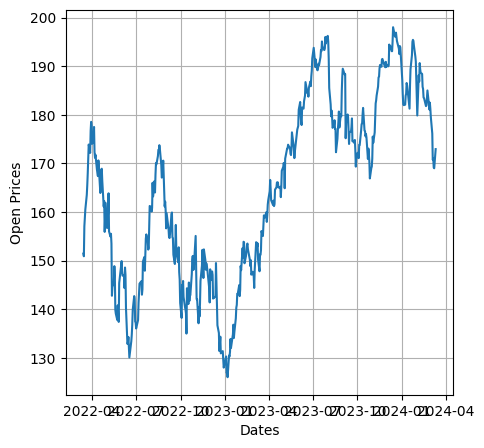

In [3]:
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
data = pd.read_csv('AAPL.csv', sep=',', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
plt.figure(figsize=(5,5))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'])

In [4]:
data.describe()


,Open,High,Low,Close,Adj Close,Volume
count,501.000000,501.000000,501.000000,501.000000,501.000000,5.010000e+02
mean,165.008424,166.804611,163.402256,165.207263,164.308408,7.014893e+07
std,18.742006,18.415741,18.966835,18.699585,18.980158,2.423456e+07
min,126.010002,127.769997,124.169998,125.019997,124.166641,2.404830e+07
25%,148.869995,150.919998,147.240005,149.350006,148.119370,5.239030e+07
50%,166.460007,168.160004,165.190002,166.470001,165.340500,6.557380e+07
75%,180.669998,182.229996,178.550003,180.710007,180.238235,8.147420e+07
max,198.020004,199.619995,197.000000,198.110001,197.857529,1.826020e+08


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


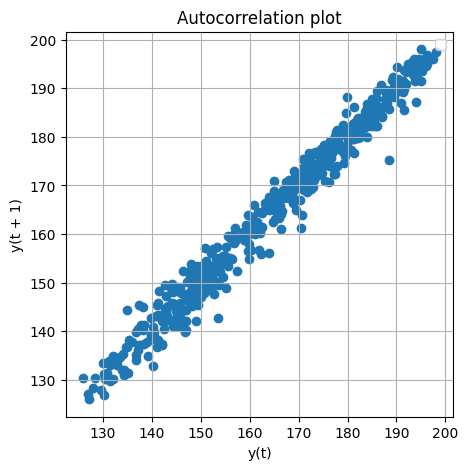

In [5]:
import pandas as pd
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(data['Open'], lag=1)
plt.title('Autocorrelation plot')
plt.grid(True)
plt.legend()


values = pd.DataFrame(data['Open'].values)
dataframe = pd.concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
# print(result)

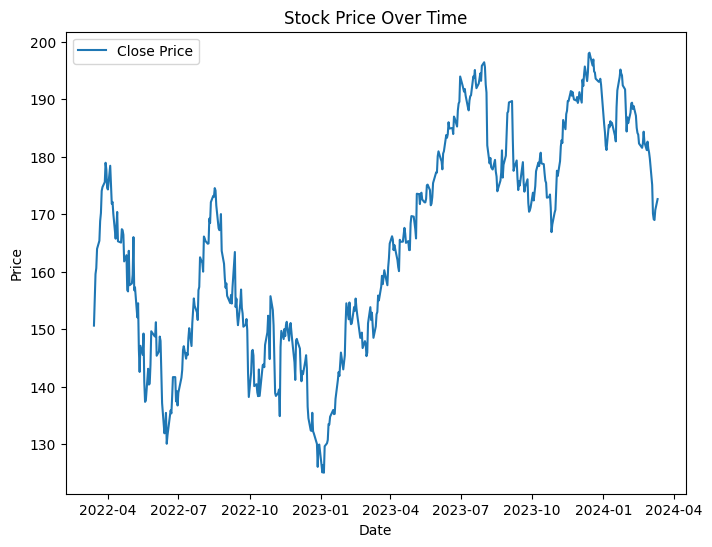

In [6]:
plt.figure(figsize=(8,6))
plt.plot(data['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Over Time')
plt.legend()
plt.show()

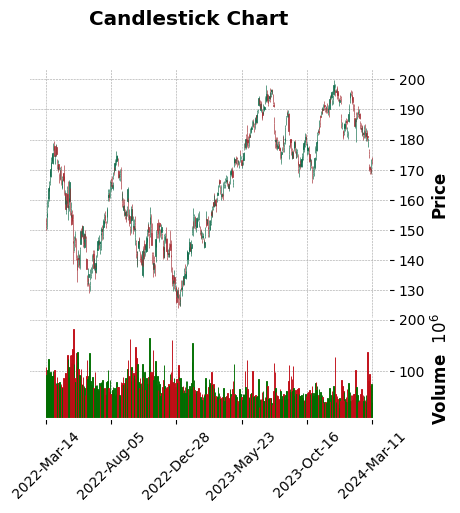

In [7]:
import mplfinance as mpf
mpf.plot(data, type='candle',
        style='charles',
        title='Candlestick Chart',
        volume=True, figsize=(5,5)
        )

In [8]:
#splitting the data into 70% training and 30% testing
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
# plt.figure(figsize=(5,5))
# plt.grid(True)
# plt.xlabel('Dates')
# plt.ylabel('Open Prices')
# plt.plot(data['Open'], 'green', label='Train data')
# plt.plot(test_data['Open'], 'blue', label='Test data')
# plt.legend()

In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# preprocessing training data
train = train_data.iloc[:, 0:1].values 
scaler = MinMaxScaler() 
train_scaled = scaler.fit_transform(train)
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) 
    y_train.append(train_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #Reshaping
# from numpy.random import seed 
# seed(2019)

In [10]:
#preprocessing testing data
test = test_data.iloc[:, 0:1].values 
scaler = MinMaxScaler() 
test_scaled = scaler.fit_transform(test)
timesteps = 7
X_test = []
y_test = []
for i in range(timesteps, test.shape[0]):
    X_test.append(test_scaled[i-timesteps:i, 0]) 
    y_test.append(test_scaled[i, 0]) 
X_test, y_test = np.array(X_test), np.array(y_test)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Bidirectional


model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.20))

model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.25))

model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=50)))
model.add(Dropout(0.25))

model.add(Dense(units=1))

In [12]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 40, batch_size = 32)


Epoch 1/40

14/14 [==============================] - 29s 28ms/step - loss: 0.0957
Epoch 2/40
14/14 [==============================] - 0s 24ms/step - loss: 0.0215
Epoch 3/40
14/14 [==============================] - 0s 27ms/step - loss: 0.0120
Epoch 4/40
14/14 [==============================] - 0s 30ms/step - loss: 0.0074
Epoch 5/40
14/14 [==============================] - 1s 38ms/step - loss: 0.0075
Epoch 6/40
14/14 [==============================] - 0s 30ms/step - loss: 0.0070
Epoch 7/40
14/14 [==============================] - 0s 30ms/step - loss: 0.0065
Epoch 8/40
14/14 [==============================] - 0s 32ms/step - loss: 0.0065
Epoch 9/40
14/14 [==============================] - 1s 43ms/step - loss: 0.0065
Epoch 10/40
14/14 [==============================] - 1s 44ms/step - loss: 0.0061
Epoch 11/40
14/14 [==============================] - 1s 44ms/step - loss: 0.0055
Epoch 12/40
14/14 [==============================] - 1s 42ms/step - loss: 0.0061
Epoch 13/40
14/14 [===============

2/2 [==============================] - 6s 10ms/step
predicted stock price for tomorrow:  [170.55649]


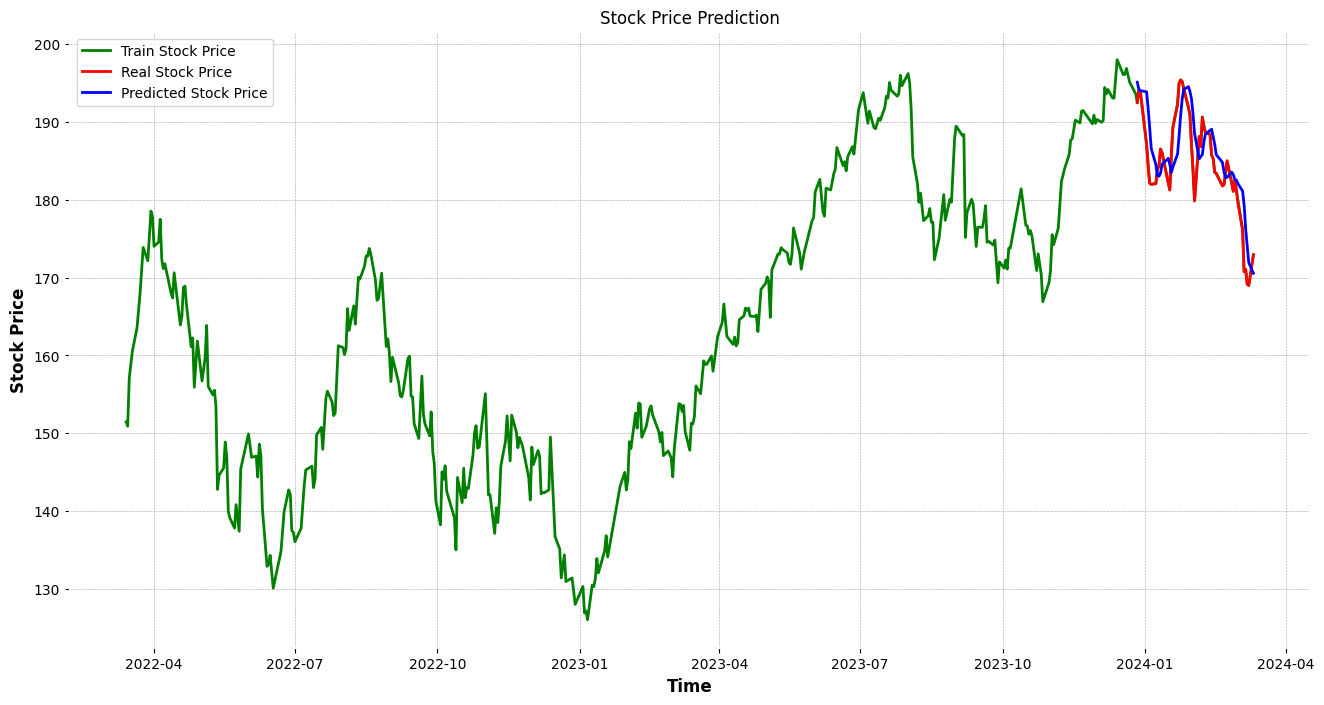

In [13]:
real_stock_price = test_data.iloc[:,0:1].values
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)

test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)

predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
print("predicted stock price for tomorrow: ",predicted_stock_price[len(predicted_stock_price)-1])

plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

mse14 = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse14))
mae14 = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae14))
rmse14 = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse14))
r214 = r2_score(real_stock_price, predicted_stock_price)
print('R2 Score: ' + str(r214))

MSE: 15.994787911679023
MAE: 3.2787173402075647
RMSE: 3.999348435892905
R2 Score: 0.6257411483094029
